In [9]:
# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import os
import numpy as np
from plotly import graph_objects as go
import plotly.express as px
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import math
from torchvision import models, datasets # For pre-trained models (for transfer learning)


In [10]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


## Hyperparameter List

In [11]:
TARRGET_SIZE = (224, 224) # what size we want to reshape to for data augmentation (see below)
BATCH_SIZE = 32

## Data Exploration, Visualization, Pre-Processing



In [12]:
def load_dataset_dataframes():
  test_array = []
  train_array = []

  for category in os.listdir('Testing'):
    for file in os.listdir(os.path.join('Testing', category)):
        # Ensure we're only adding image files
        file_path = os.path.join('Testing', category, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
          test_array.append([file_path, category])

  test_dataframe = pd.DataFrame(test_array, columns=['file_path', 'label'])
          
  for category in os.listdir('Training'):
    for file in os.listdir(os.path.join('Training', category)):
        # Ensure we're only adding image files
        file_path = os.path.join('Training', category, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
          train_array.append([file_path, category])
  
  train_dataframe = pd.DataFrame(train_array, columns=['file_path', 'label'])
        
  return test_dataframe, train_dataframe

def load_image(image_path):
  image = Image.open(image_path)
  image = image.resize((64, 64))
  image = np.array(image)
  image = torch.from_numpy(image).float()
  return image

### Exploring the Data

In [13]:
# Display a couple random samples (re-run to load a new image)
train_dataframe, test_dataframe = load_dataset_dataframes()
random_image_path = np.random.choice(test_dataframe['file_path'])
random_image = load_image(random_image_path)
display(random_image_path)
px.imshow(random_image, color_continuous_scale='gray').show()

'Training\\notumor\\Tr-no_1050.jpg'

In [70]:
# Plot the dataset
def plot_dataset(dataset_type):

    base_directory = os.getcwd()
    categories = os.listdir(base_directory+'/'+dataset_type)

    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    print('categories are: ', categories)
    print('counts are: ', counts)

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()


categories are:  ['pituitary', 'meningioma', 'notumor', 'glioma']
counts are:  [1457, 1339, 1595, 1321]


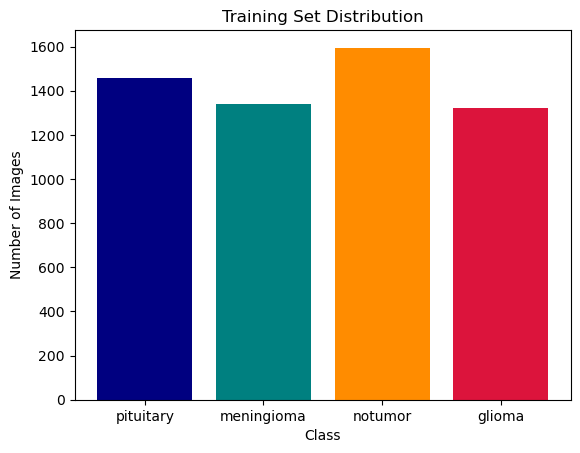

categories are:  ['pituitary', 'meningioma', 'notumor', 'glioma']
counts are:  [300, 306, 405, 300]


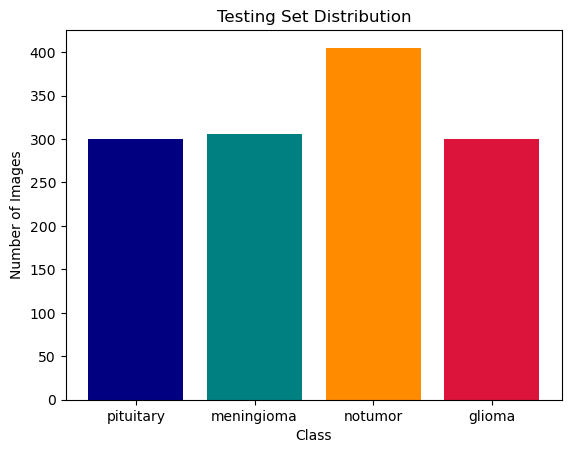

In [71]:
plot_dataset('Training')
plot_dataset('Testing')

### Data Preprocessing

In [16]:
# Important!!!! Turn categories into numbers for use within neural networks

label_map = {
    'notumor': 0,        
    'glioma': 1,         
    'meningioma': 2,     
    'pituitary': 3       
}

train_dataframe['label'] = train_dataframe['label'].map(label_map)
test_dataframe['label'] = test_dataframe['label'].map(label_map)

In [17]:
print(train_dataframe)

                             file_path  label
0      Testing\glioma\Te-glTr_0000.jpg      1
1      Testing\glioma\Te-glTr_0001.jpg      1
2      Testing\glioma\Te-glTr_0002.jpg      1
3      Testing\glioma\Te-glTr_0003.jpg      1
4      Testing\glioma\Te-glTr_0004.jpg      1
...                                ...    ...
1306  Testing\pituitary\Te-pi_0295.jpg      3
1307  Testing\pituitary\Te-pi_0296.jpg      3
1308  Testing\pituitary\Te-pi_0297.jpg      3
1309  Testing\pituitary\Te-pi_0298.jpg      3
1310  Testing\pituitary\Te-pi_0299.jpg      3

[1311 rows x 2 columns]


### Splitting into train, validation, and test sets

In [18]:
def split_test_validation(data, ratio=0.50):

    # if the list isn't divisble by 50%...
    split_index_test = math.ceil(len(data) * ratio)


    test_df = data[:split_index_test]
    val_df = data[split_index_test:]

    return test_df, val_df





test_df_split, val_df_split = split_test_validation(test_dataframe, ratio=0.5)
# Reset indices for consistency (instead of index starting from halfway, it'll start from 0)
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)


print(test_dataframe.size)
print(test_df_split.size)
print(val_df_split.size)

11424
5712
5712


In [19]:
## Making sure everything makes sense
print(test_dataframe.size)
print(test_df_split.size)
print(val_df_split.size)

11424
5712
5712


### Create Class ImageDataset
##### Inherits from Pytorch's "Dataset" class, can be used to load Data

In [20]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')  

        if self.transform:
            img = self.transform(img)
            
        return img, label

### Data Augmentation

In [21]:
train_transform = transforms.Compose([

   transforms.Resize(TARRGET_SIZE),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
# Apply Data Augmentation

final_train_dataset = ImageDataset(train_dataframe, transform=train_transform)
final_val_dataset = ImageDataset(val_df_split, transform=test_transform)
final_test_dataset = ImageDataset(test_df_split, transform=test_transform)


# DataLoader

train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(final_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Train and Test Functions (used by all models)

In [23]:
base_directory = os.getcwd()
categories = os.listdir(base_directory+'/Training')

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0  
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history

In [25]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")
    
    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Plots / Graphing Stuff

In [26]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

In [27]:
def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Separate correct and incorrect predictions
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())

    # Visualization
    # Unnormalize using your mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    num_cols = num_images // 2
    plt.figure(figsize=(15, 7))

    # Display correct predictions
    for i, img_tensor in enumerate(correct_images[:num_images // 2]):
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[correct_labels[i]]}\nPred: {categories[correct_preds[i]]}", color='green', fontsize=15)
        plt.axis('off')

    # Display incorrect predictions
    for i, img_tensor in enumerate(incorrect_images[:num_images // 2]):
        if i >= len(incorrect_images):
            plt.axis('off')
            continue
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[incorrect_labels[i]]}\nPred: {categories[incorrect_preds[i]]}", color='red', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## (Model 1) Custom CNN

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (B, 3, 224, 224) -> (B, 32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (B, 32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> (B, 64, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (B, 64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # -> (B, 128, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (B, 128, 28, 28)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # -> (B, 256, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> (B, 256, 14, 14)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # -> (B, 256*14*14)
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)  #Output layer for 4 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
custom_model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)

print("Starting training of custom CNN...")
history_custom = train_model(custom_model, train_loader, val_loader, criterion, optimizer, num_epochs=30, name='custom_cnn')


Starting training of custom CNN...


C:\Users\rayaa\AppData\Local\Temp\ipykernel_21012\1382513261.py:22: UserWarning:

Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)



Epoch [1/30]
Train Loss: 1.2636, Train Accuracy: 41.80%
Val Loss: 0.7782, Val Accuracy: 69.36%
################################################################################
Epoch [2/30]
Train Loss: 1.0550, Train Accuracy: 53.55%
Val Loss: 0.5426, Val Accuracy: 82.84%
################################################################################
Epoch [3/30]
Train Loss: 0.9467, Train Accuracy: 62.17%
Val Loss: 0.3585, Val Accuracy: 92.44%
################################################################################
Epoch [4/30]
Train Loss: 0.8199, Train Accuracy: 66.74%
Val Loss: 0.4698, Val Accuracy: 89.85%
################################################################################
Epoch [5/30]
Train Loss: 0.7595, Train Accuracy: 69.57%
Val Loss: 0.2931, Val Accuracy: 94.96%
################################################################################
Epoch [6/30]
Train Loss: 0.6983, Train Accuracy: 71.85%
Val Loss: 0.2447, Val Accuracy: 94.47%
#########################

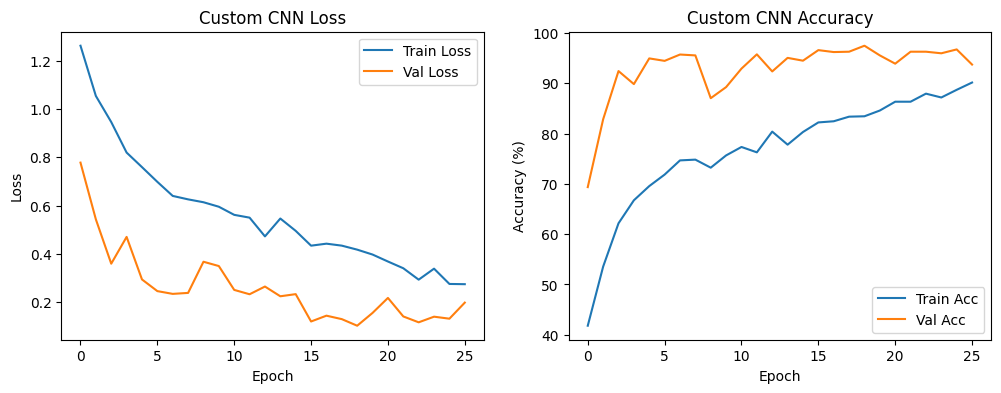

In [ ]:
test_model(custom_model, test_loader)

plot_training_history(history_custom, model_name="Custom CNN")

visualize_predictions(custom_model, test_loader, num_images=10)


## (Model 2) ResNet

In [29]:
# Load pretrained ResNet-34 model
#transfer_model = models.resnet34(pretrained=True)
transfer_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\rayaa/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 65.1MB/s]


In [30]:
# Freeze all layers except the final fully connected layer
for param in transfer_model.parameters():
    param.requires_grad = False

In [31]:
# use the "fc" field to get the FINAL fully connected layer in the model
num_ftrs = transfer_model.fc.in_features
transfer_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  
    nn.ReLU(),                
    nn.Dropout(0.3),           
    nn.Linear(512, 4)          
)

# Move model to device
transfer_model = transfer_model.to(device)

In [32]:
optimizer = optim.Adam(transfer_model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Train Model

In [33]:
print("Starting transfer learning training...")

history = train_model(transfer_model, train_loader, val_loader, criterion, optimizer, num_epochs=30, name='resnet18')

Starting transfer learning training...
Epoch [1/30]
Train Loss: 0.8817, Train Accuracy: 63.62%
Val Loss: 0.8805, Val Accuracy: 65.58%
################################################################################
Epoch [2/30]
Train Loss: 0.5705, Train Accuracy: 78.11%
Val Loss: 0.3022, Val Accuracy: 91.84%
################################################################################
Epoch [3/30]
Train Loss: 0.5454, Train Accuracy: 78.49%
Val Loss: 0.4343, Val Accuracy: 87.15%
################################################################################
Epoch [4/30]
Train Loss: 0.4679, Train Accuracy: 82.53%
Val Loss: 0.1431, Val Accuracy: 96.85%
################################################################################
Epoch [5/30]
Train Loss: 0.4239, Train Accuracy: 82.84%
Val Loss: 0.4199, Val Accuracy: 85.40%
################################################################################
Epoch [6/30]
Train Loss: 0.4056, Train Accuracy: 84.90%
Val Loss: 0.2076, Val Acc

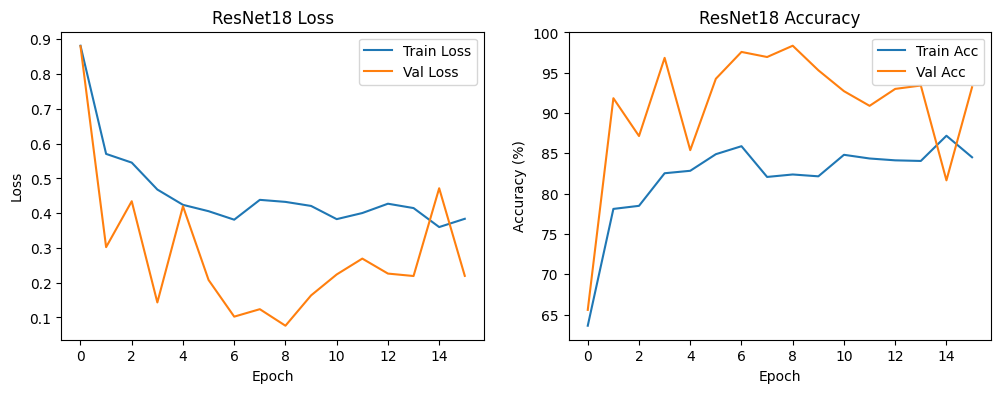

In [34]:
plot_training_history(history, model_name="ResNet18")


Loading best model for testing...
Test Accuracy: 60.92%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.50      0.81      0.62       196
  meningioma       0.70      0.93      0.80      1321
     notumor       0.92      0.26      0.41      1339
   pituitary       0.00      0.00      0.00         0

    accuracy                           0.61      2856
   macro avg       0.53      0.50      0.46      2856
weighted avg       0.79      0.61      0.61      2856



c:\Users\rayaa\Documents\GitHub\omscs-7643-final-project\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\rayaa\Documents\GitHub\omscs-7643-final-project\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\rayaa\Documents\GitHub\omscs-7643-final-project\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



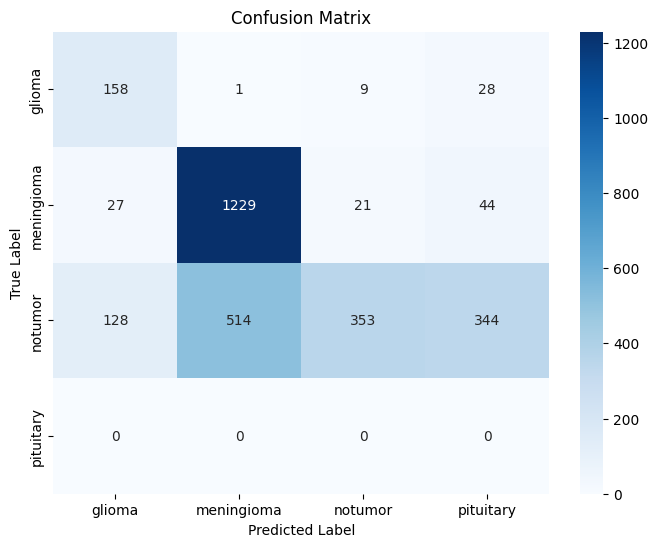

In [35]:
print("\nLoading best model for testing...")
transfer_model.load_state_dict(torch.load('best_brain_tumor_resnet18.pth'))
test_model(transfer_model, test_loader)

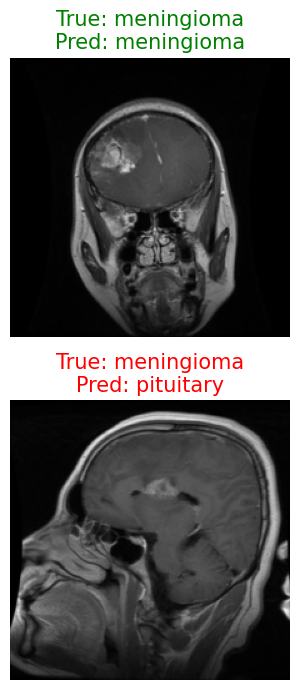

In [36]:
visualize_predictions(transfer_model, test_loader, 2)

## Gradient Visualization